In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import imageio

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


In [2]:
# Camera Calibration code cell

cal_images = os.listdir('camera_cal/')
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
for image in cal_images:
    img = mpimg.imread('camera_cal/'+image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if (ret == True):
        imgpoints.append(corners)
        objpoints.append(objp)


In [3]:
### Necessary functions 

def undistort(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def perspective_transform(img):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image=cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    return warped_image, Minv

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def hls_select(img, output = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    if (output == 's'):
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    if (output == 'l'):
        binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    if (output == 'h'):
        binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, output = 's', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,1]
    v_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    if (output == 's'):
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    if (output == 'v'):
        binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    if (output == 'h'):
        binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary_output

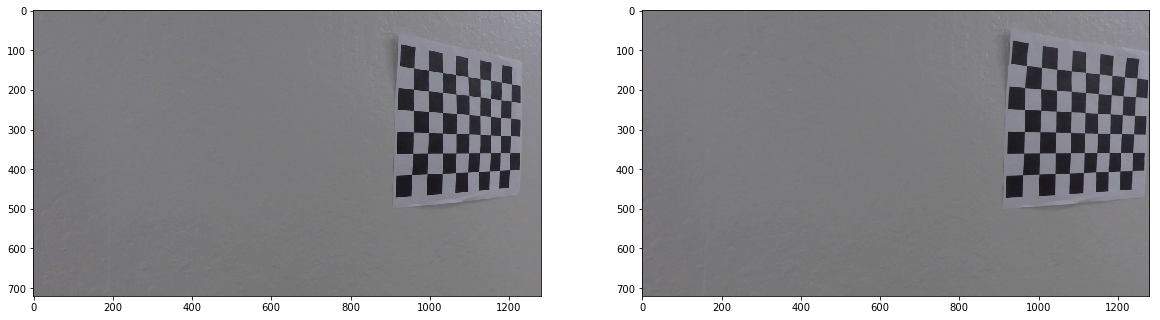

In [19]:
### Camera Calibration, Undistorting the chess board image for plotting
fig = plt.figure(figsize = (20,40))
test_images = os.listdir('test_images/')
image = mpimg.imread('camera_cal/' + cal_images[5])
im1 = fig.add_subplot(1,2,1)
im1.imshow(image)
plt.imsave('output_images/distort_image.jpg',image)
undistorted = undistort(image)
im2 = fig.add_subplot(1,2,2)
im2.imshow(undistorted)
plt.imsave('output_images/undistort_image.jpg', undistorted)

In [5]:
img = mpimg.imread('test_images/' + test_images[3])
image = undistort(img)
plt.imsave('output_images/undistort_road_image.jpg', image)

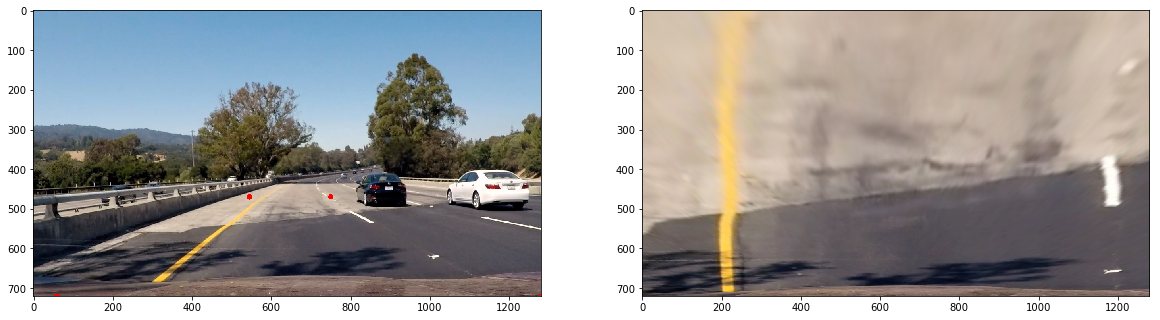

In [20]:
### Making perspective transform of test images to study and determine the shape of the source polygon points
### tested with all test images

src = np.float32([[545,470],[750, 470],
                      [60, 720],[1280, 720]])

dst = np.float32([[0, 0], [1280, 0], 
                     [0, 720],[1280, 720]])



#test_images = os.listdir('test_images/')
img = mpimg.imread('test_images/' + test_images[5])
img1 = mpimg.imread('test_images/' + test_images[5])
fig1 = plt.figure(figsize = (20,40))
im1 = fig1.add_subplot(1,2,1)
road_image = cv2.circle(img,(src[0][0],src[0][1]), 7, (255,0,0), -1)
road_image = cv2.circle(img,(src[1][0],src[1][1]), 7, (255,0,0), -1)
road_image = cv2.circle(img,(src[2][0],src[2][1]), 7, (255,0,0), -1)
road_image = cv2.circle(img,(src[3][0],src[3][1]), 7, (255,0,0), -1)
im1.imshow(img)

plt.imsave('output_images/Road_image_with_points.jpg',img)
im2 = fig1.add_subplot(1,2,2)
image = undistort(img1)
p_image, Minv_image = perspective_transform(image)
im2.imshow(p_image)
plt.imsave('output_images/pers_road_image.jpg', p_image)

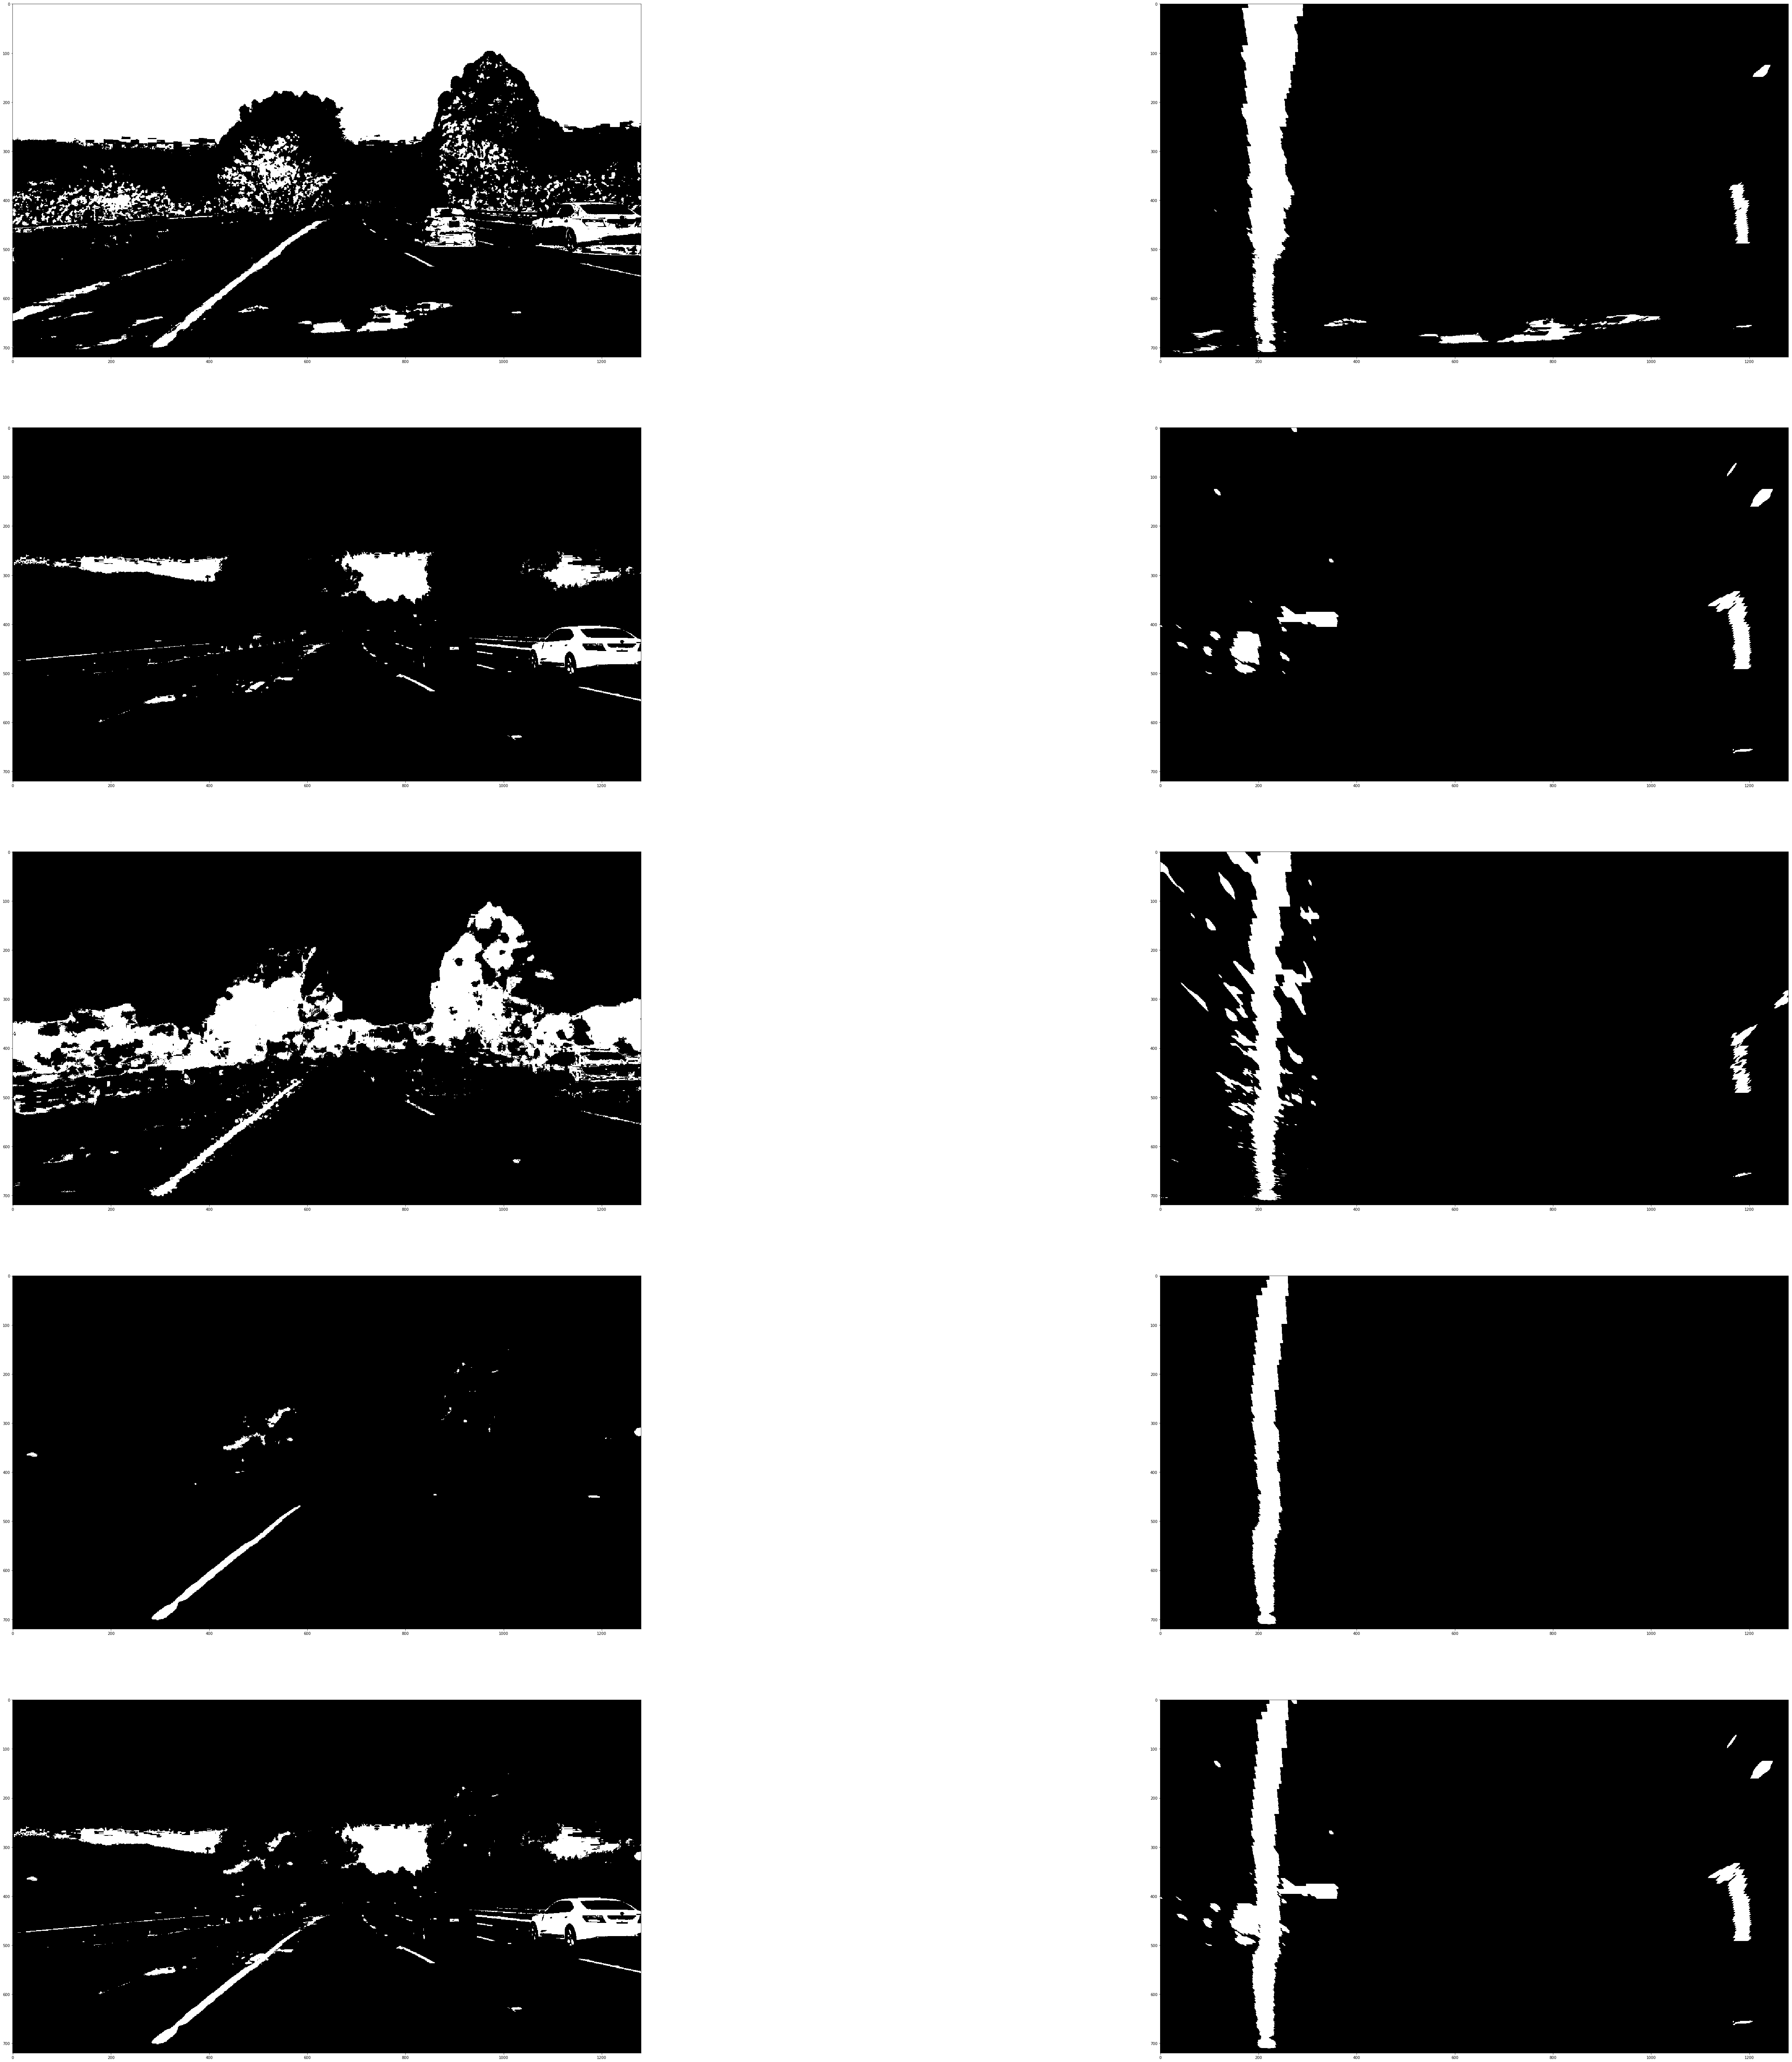

In [21]:
def test_select(img, thresh=(0, 255), i = 2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)# 1) Convert to HLS color space
    S = hls[:,:,i]# 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)# 3) Return a binary image of threshold result
    binary_output[(S > thresh[0])&(S <= thresh[1])] = 1 # placeholder line
    return binary_output
def select(img, thresh=(0, 255), i = 2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)# 1) Convert to HLS color space
    S = hls[:,:,i]# 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)# 3) Return a binary image of threshold result
    binary_output[(S > thresh[0])&(S <= thresh[1])] = 1 # placeholder line
    return binary_output

fig = plt.figure(figsize = (100,100))
s = test_select(image, thresh=(100, 255))
l = test_select(image, thresh=(200, 255), i = 1)
h = test_select(image, thresh=(17, 30), i = 0)
b = select(image, thresh=(155, 255))

s_test, Minv_test = perspective_transform(s)
im1 = fig.add_subplot(5,2,1)
im1.imshow(s, cmap = 'gray')

im1 = fig.add_subplot(5,2,2)
im1.imshow(s_test, cmap = 'gray')
plt.imsave('output_images/S_image.jpg', s_test, cmap = 'gray')

l_test, Minv_test = perspective_transform(l)
im1 = fig.add_subplot(5,2,3)
im1.imshow(l, cmap = 'gray')

im1 = fig.add_subplot(5,2,4)
im1.imshow(l_test, cmap = 'gray')
plt.imsave('output_images/L_image.jpg', l_test, cmap = 'gray')

h_test, Minv_test = perspective_transform(h)
im1 = fig.add_subplot(5,2,5)
im1.imshow(h, cmap = 'gray')

im1 = fig.add_subplot(5,2,6)
im1.imshow(h_test, cmap = 'gray')
plt.imsave('output_images/H_image.jpg', h_test, cmap = 'gray')


b_test, Minv_test = perspective_transform(b)
im1 = fig.add_subplot(5,2,7)
im1.imshow(b, cmap = 'gray')

im1 = fig.add_subplot(5,2,8)
im1.imshow(b_test, cmap = 'gray')
plt.imsave('output_images/B_image.jpg', b_test, cmap = 'gray')

co = np.zeros_like(s)
co[(l == 1)| (b == 1)] = 1
im1 = fig.add_subplot(5,2,9)
im1.imshow(co, cmap = 'gray')

co_test, Minv_test = perspective_transform(co)
im1 = fig.add_subplot(5,2,10)
im1.imshow(co_test, cmap = 'gray')
plt.imsave('output_images/comb_image.jpg', co_test, cmap = 'gray')

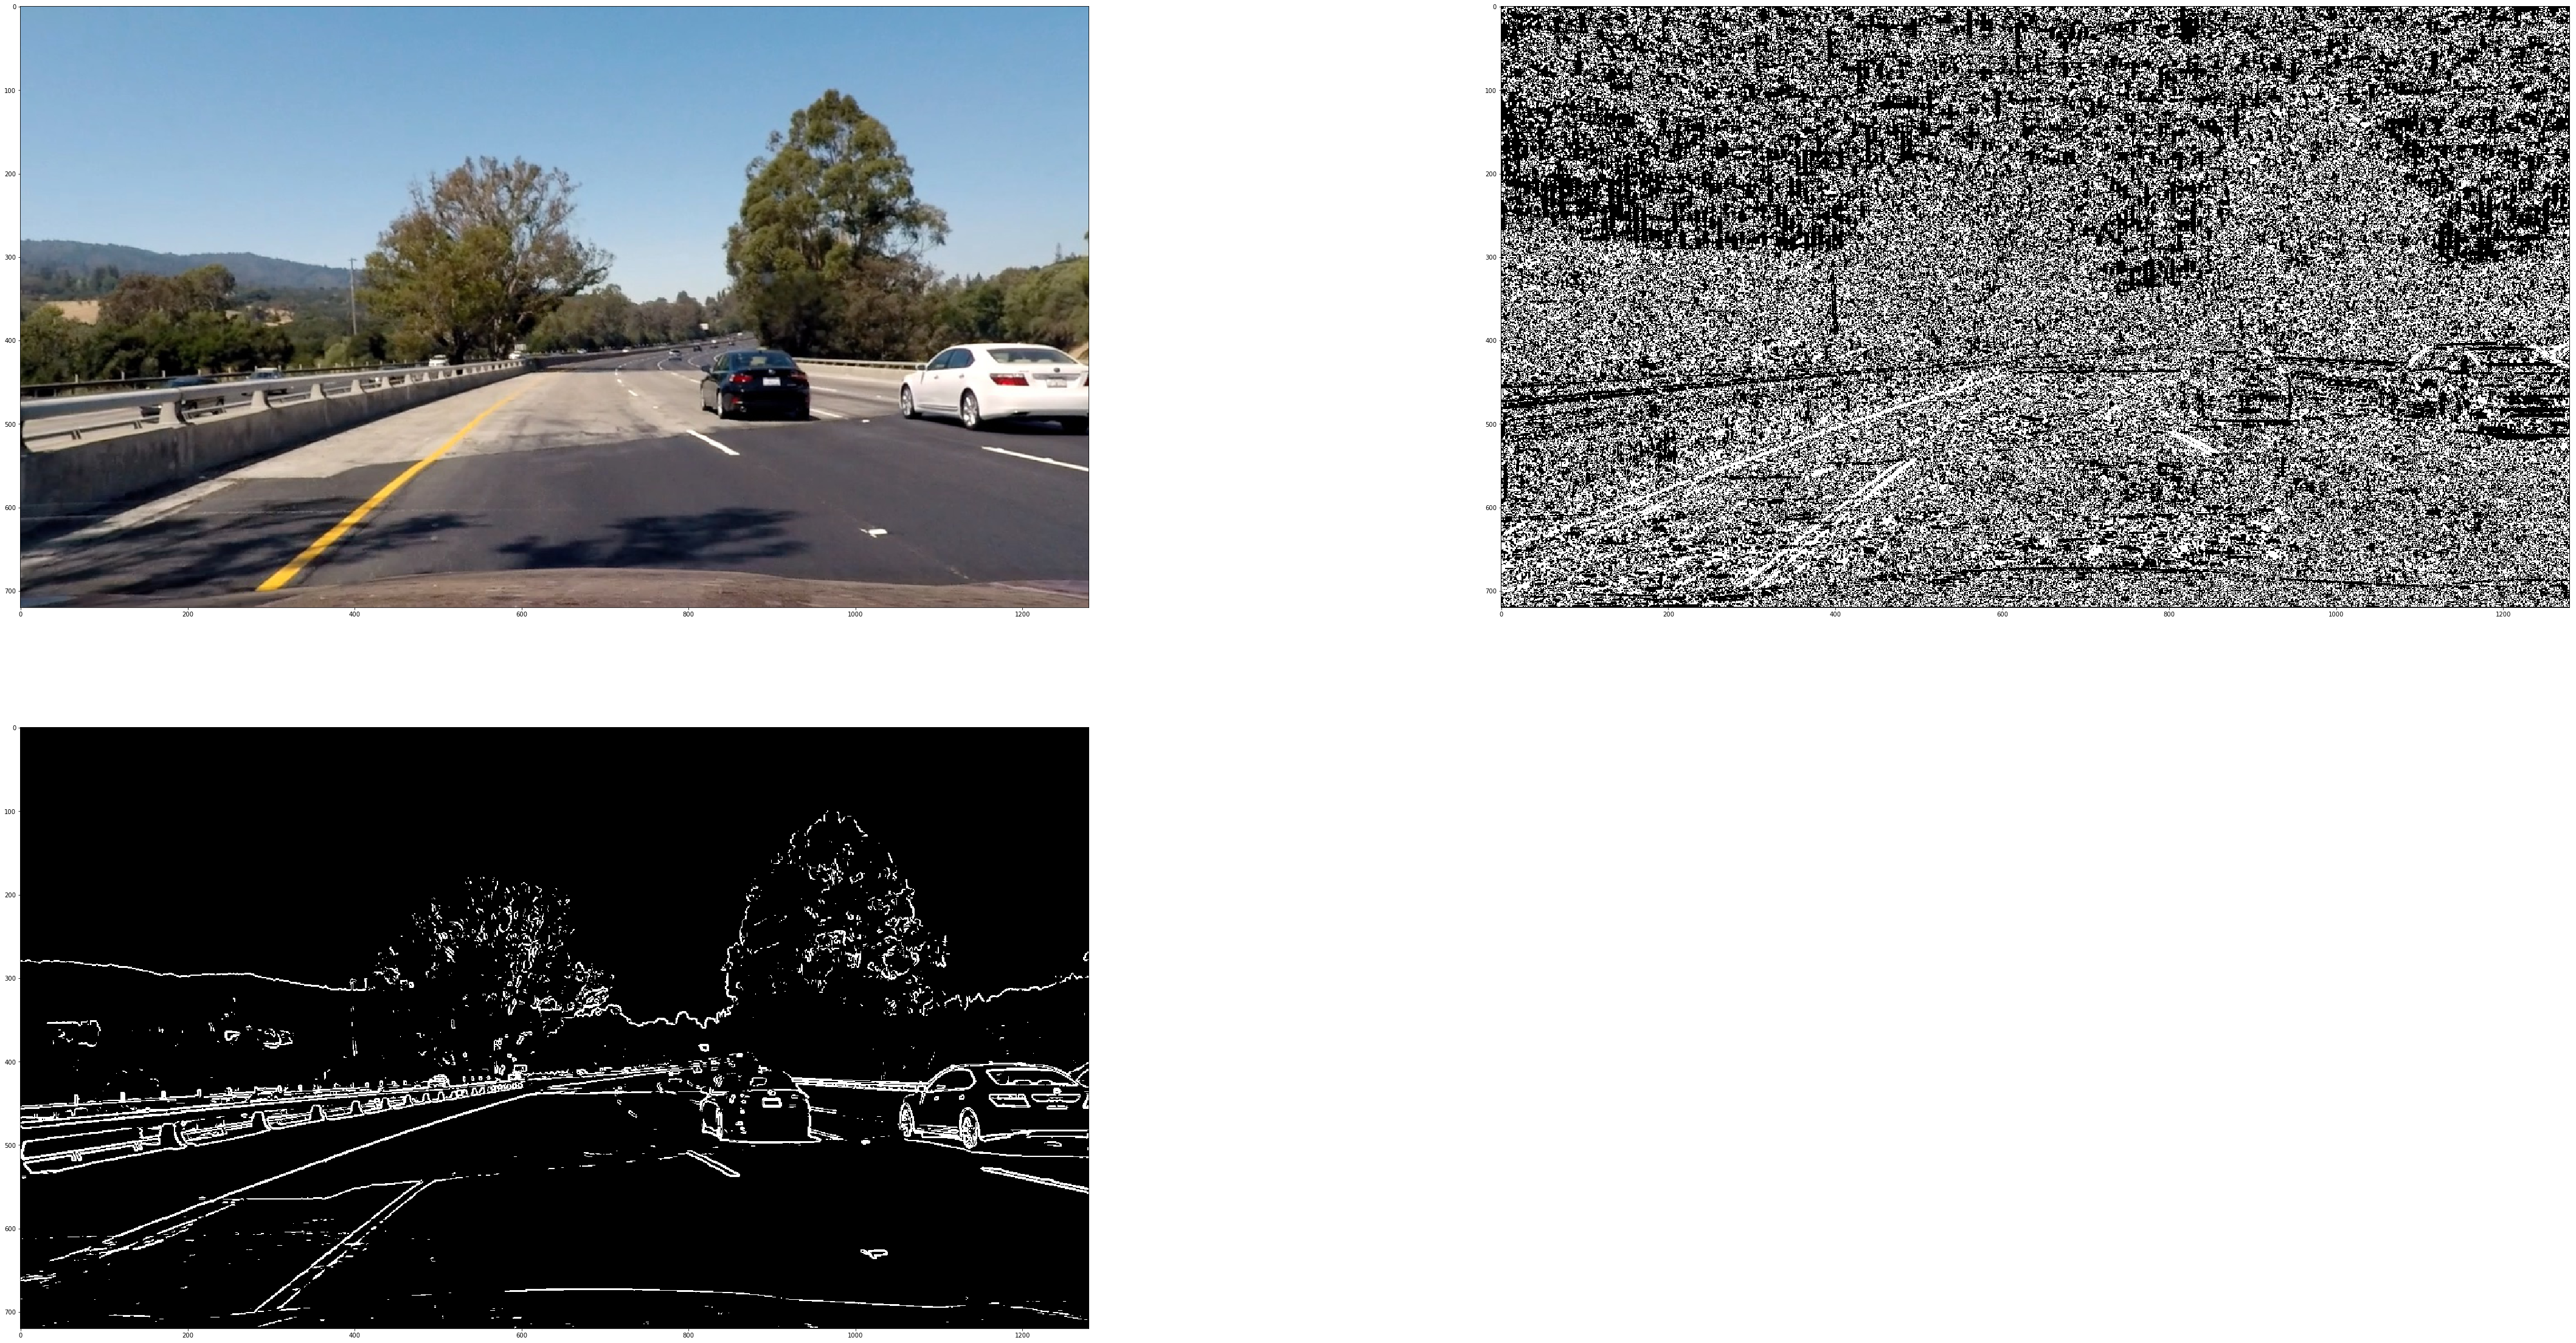

In [22]:
### gradient
fig2 = plt.figure(figsize = (80,40))
im1 = fig2.add_subplot(2,2,1)
im1.imshow(image)

im2 = fig2.add_subplot(2,2,2)
dir_image = dir_threshold(image, thresh=(3*np.pi/16, 7*np.pi/16))
im2.imshow(dir_image, cmap = 'gray')

im3 = fig2.add_subplot(2,2,3)
mag_image = mag_thresh(image, mag_thresh=(50, 200))
im3.imshow(mag_image, cmap = 'gray')


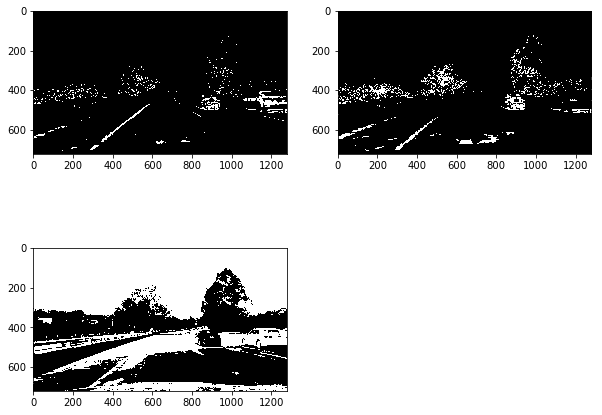

In [23]:
fig3 = plt.figure(figsize = (10,8))

im4 = fig3.add_subplot(2,2,1)
s_hls_image = hls_select(image, thresh=(150, 255))
im4.imshow(s_hls_image, cmap = 'gray')

im5 = fig3.add_subplot(2,2,2)
s_hsv_image = hsv_select(image,output = 's', thresh=(150, 255))
im5.imshow(s_hsv_image, cmap = 'gray')

im6 = fig3.add_subplot(2,2,3)
l_image = hls_select(image,output = 'l', thresh=(100, 255))
im6.imshow(l_image, cmap = 'gray')

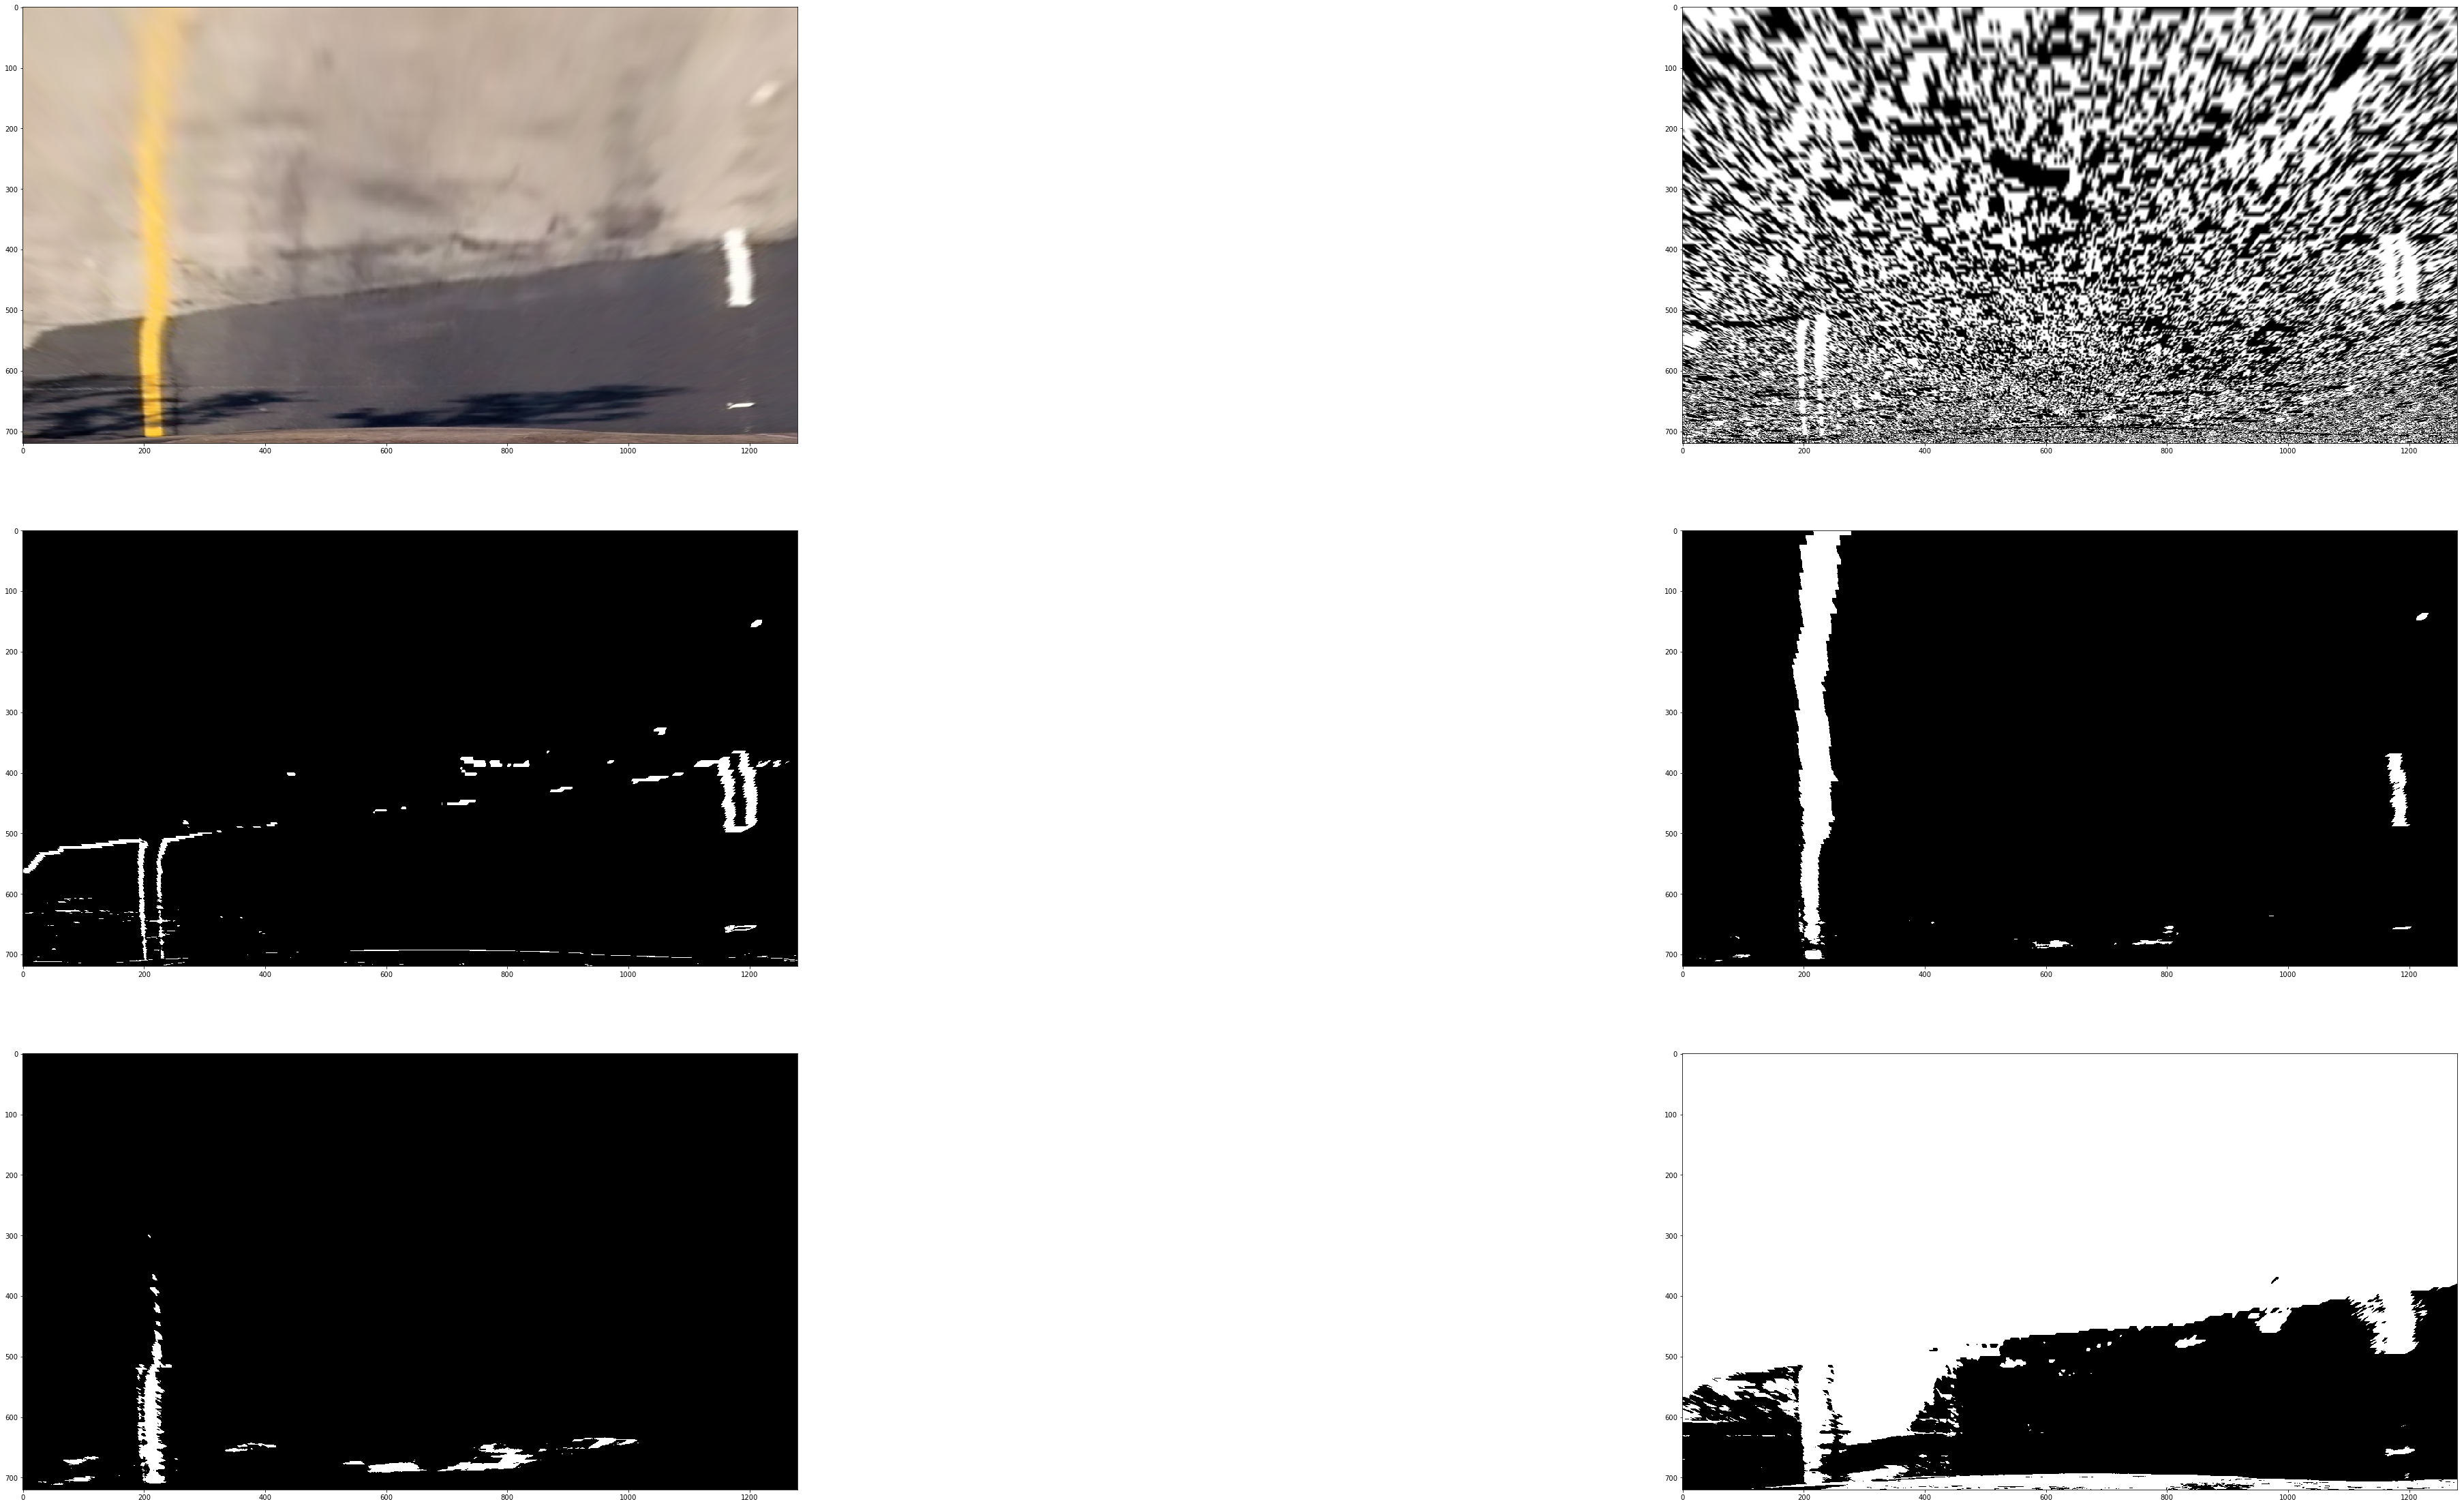

In [24]:
fig2 = plt.figure(figsize = (80,40))
im1 = fig2.add_subplot(3,2,1)
p_image, Minv_image = perspective_transform(image)
im1.imshow(p_image)

im2 = fig2.add_subplot(3,2,2)
dir_image_p, Minv_dir = perspective_transform(dir_image)
im2.imshow(dir_image_p, cmap = 'gray')

im3 = fig2.add_subplot(3,2,3)
mag_image_p, Minv_mag = perspective_transform(mag_image)
im3.imshow(mag_image_p, cmap = 'gray')
plt.imsave('output_images/Mag_image.jpg', mag_image_p, cmap = 'gray')

im4 = fig2.add_subplot(3,2,4)
s_hls_image_p, Minv_s = perspective_transform(s_hls_image)
im4.imshow(s_hls_image_p, cmap = 'gray')

im5 = fig2.add_subplot(3,2,5)
s_hsv_image_p, Minv_h = perspective_transform(s_hsv_image)
im5.imshow(s_hsv_image_p, cmap = 'gray')

im6 = fig2.add_subplot(3,2,6)
l_image_p, Minv_l = perspective_transform(l_image)
im6.imshow(l_image_p, cmap = 'gray')

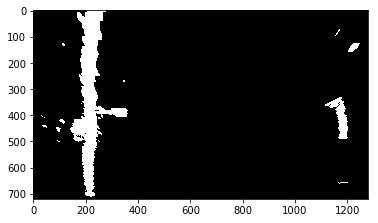

In [25]:

###test combinations
combined = np.zeros_like(s)
combined[((s==1)&(h==1))|(l == 1)|(b == 1)] = 1

binary_warped, Minv_comb = perspective_transform(combined)
imf = plt.imshow(binary_warped, cmap = 'gray')
plt.show()

8991.51201445 1154.43592139
2950.98379609 m 328.867502387 m


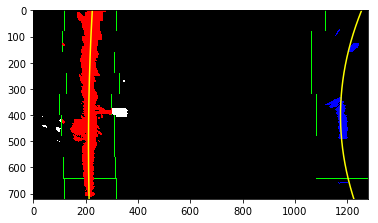

In [26]:
### Using the moving window average for the values of the best combination to track the lane line over the image using a histogram

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = int(binary_warped.shape[0]) - (window+1)*window_height
    win_y_high = int(binary_warped.shape[0]) - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    #cv2.rectangle(out_img[:,:,:2],(300,0),(580,250),(0,255,0), 2)
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

#left_points = np.zeros(len(ploty),2)
left_points = np.vstack((left_fitx,ploty))
left_points = np.array(left_points.T, np.int32)

right_points = np.vstack((right_fitx, ploty))
right_points = np.array(right_points.T, np.int32)
# Extract left and right line pixel positions
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
cv2.polylines(out_img, [left_points],True,(255,255,0))
cv2.polylines(out_img, [right_points],True,(255,255,0))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.imsave('output_images/ploy_fit_image.jpg', out_img)

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

#left, right, left_ind, right_ind = find_lane_lines(binary_warped)
#plot_lane_lines(left_ind, right_ind)

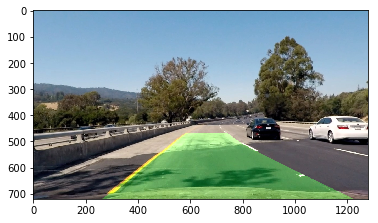

In [27]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv_comb, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.imsave('output_images/warped_back_image.jpg', result)



In [28]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [31]:
def process_video(img):    

    image=undistort(img)
    s = test_select(image, thresh=(100, 255))
    l = test_select(image, thresh=(200, 255), i = 1)
    h = test_select(image, thresh=(17, 30), i = 0)
    b = select(image, thresh=(155, 255))
    binary_warped=np.zeros_like(b)
    binary_warped[(l==1)|(b==1)]=1
    binary_warped,Minv=perspective_transform(binary_warped)

    if not Left.detected:
        
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
       
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)

        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]

        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
               
        y_eval = np.max(lefty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # radius of curvature is in meters

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image 
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
       
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        num_rows=binary_warped.shape[0]

        midpoint=left_fit[0]*num_rows**2 + left_fit[1]*num_rows + left_fit[2] + right_fit[0]*num_rows**2 + right_fit[1]*num_rows + right_fit[2]

        midpoint=int(midpoint/2)

        midp_warped=np.array(([midpoint],[num_rows],[1]))
        midp_unwarped_homogeous=np.matmul(Minv,midp_warped)

        pixels_off_the_center=abs(int(midp_unwarped_homogeous[0]/midp_unwarped_homogeous[2])-640)
        meters_off_the_center=pixels_off_the_center*(3.7/700)

       
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

        Left.current_fit=left_fit
        Right.current_fit=right_fit
        Left.detected=True
        Right.detected=True        
    
    else:        
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        left_fit=Left.current_fit
        right_fit=Right.current_fit
        
        plt.imshow(binary_warped,cmap='gray')
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        #  extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
 
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        y_eval = np.max(lefty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        
        
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        
        Left.current_fit=left_fit
        Right.current_fit=right_fit
        
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        num_rows=binary_warped.shape[0]

        
        midpoint=left_fit[0]*num_rows**2 + left_fit[1]*num_rows + left_fit[2] + right_fit[0]*num_rows**2 + right_fit[1]*num_rows + right_fit[2]

        midpoint=int(midpoint/2)

        midp_warped=np.array(([midpoint],[num_rows],[1]))
        midp_unwarped_homogeous=np.matmul(Minv,midp_warped)

        pixels_off_the_center=abs(int(midp_unwarped_homogeous[0]/midp_unwarped_homogeous[2])-640)
        meters_off_the_center=pixels_off_the_center*(3.7/700)

        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)            
       
    if midpoint > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(meters_off_the_center), (100,80),
                     fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(meters_off_the_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
            
    cv2.putText(result, 'Radius of Curvature {:.2f}(m)'.format(left_curverad), (120,140),fontFace = 16
                , fontScale = 2, color=(255,255,255), thickness = 2)
   
    return result
    

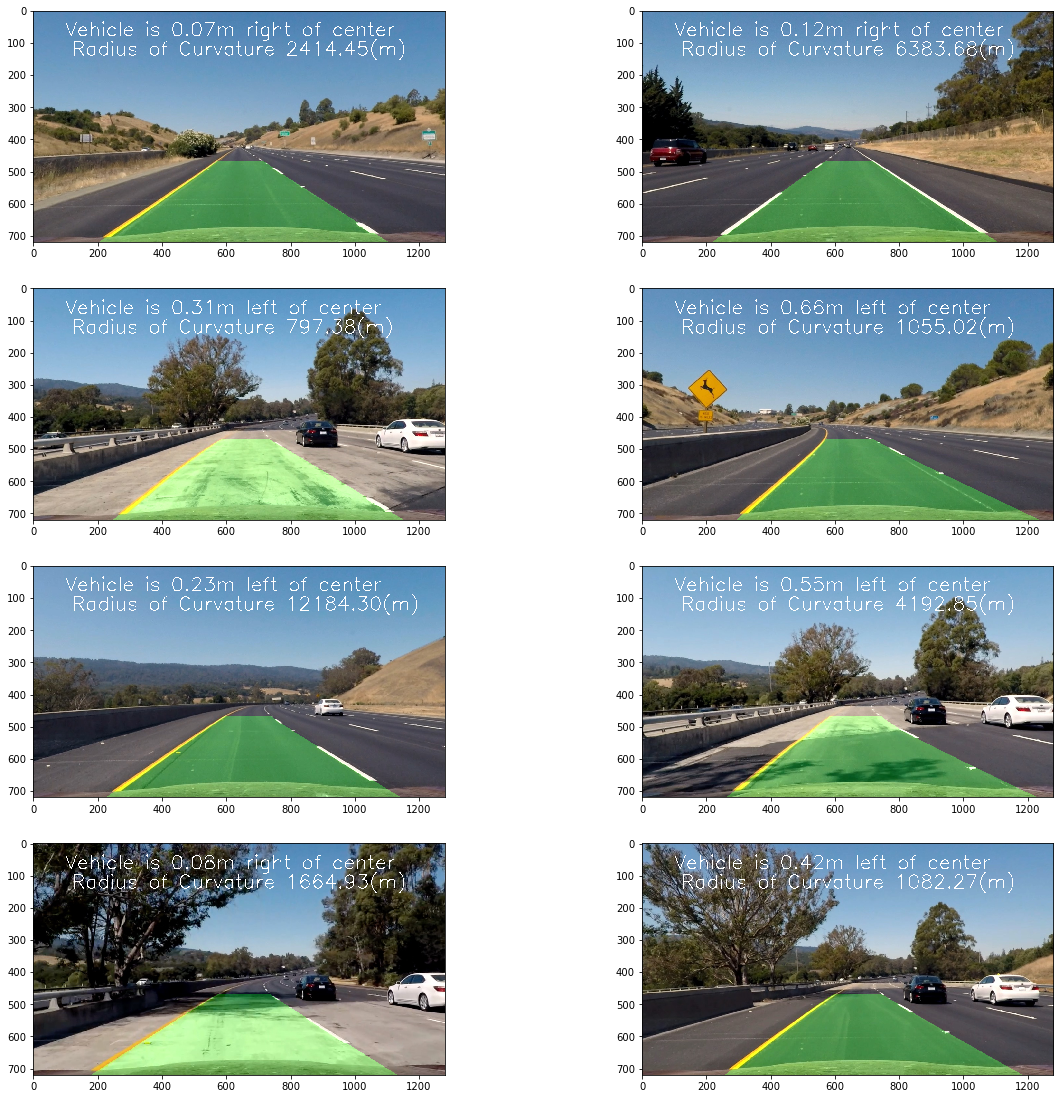

In [32]:
Left=Line()
Right=Line()
res = plt.figure(figsize = (20,40))
i = 0
n = len(test_images)
for img in range(len(test_images)):
    i += 1
    imag = mpimg.imread('test_images/'+test_images[img])
    im = res.add_subplot(n,2,i)
    a=process_video(imag)
    im.imshow(a)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [35:10<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



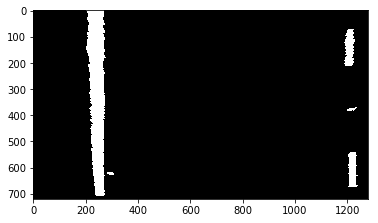

In [17]:
from moviepy.editor import VideoFileClip
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)